# Unidad 4: Aprendizaje supervisado y semisupervisado
Los problemas son generalistas a propósito (tienen muchas formas de ser resueltos dependiendo de las decisiones que vayas tomando). Son ejemplos perfectos de lo que podría solicitarse el día del examen final (de hecho, los del examen estarán más guiados, incluso). El primer problema está pensado para ser resuelto usando técnicas de aprendizaje supervisado.


## Enunciado



### Problema 2: Fallos de producto
Ayuda a una empresa a mejorar su producto prediciendo cuándo fallará. El problema principal es que detectar, notificar y registrar los fallos es un proceso muy costoso, por lo que no se dispone de todas las etiquetas finales que permitirían entrenar perfectamente al modelo.

1. Realiza un AED sobre el conjunto de datos.
*  Estadísticos iniciales. 0.2 puntos
*  Distribuciones de las variables numéricas del conjunto de datos. 0.3 puntos
*  Matriz de correlación. 0.5 puntos
2. Realiza el preprocesamiento de datos de tu problema.
*  Reserva un conjunto de datos para validación y otro para testeo. 0.5 puntos
*  Columnas inútiles, valores sin sentido y atípicos. 1 puntos
*  Tratamiento de valores nulos. 0.5 puntos
*  Análisis de variabilidad. 0.5 puntos
*  Columnas categóricas. 0.5 punto
*  Reducción de la dimensionalidad. 1 punto
3. Realiza un etiquetado automático. 1 punto
4. Entrena y optimiza distintos modelos supervisados.
*  Modelo 1. 1 punto
*  Modelo 2. 1 punto
*  Modelo 3. 1 punto
5.  Crea un modelo ensemble y explica el criterio que utilizas. 1 punto

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report


## Clonado de repositorio y carga de datos

**Objetivo y plan**
- Voy a clonar el repo de datasets si no existe.
- Busco y descomprimo datasets.zip.
- Localizo fallos_producto.csv sin rutas rigidas y lo cargo.

In [2]:

# 1) Clonar repo si no existe
if not os.path.exists("PIA_Preparar_examen"):
    !git clone https://github.com/kachytronico/PIA_Preparar_examen

# 2) Buscar datasets.zip
!find . -name "datasets.zip"

# 3) Localizar datasets.zip con Python minimo
zip_path = None
for root, _, files in os.walk("."):
    if "datasets.zip" in files:
        zip_path = os.path.join(root, "datasets.zip")
        break
if zip_path is None:
    raise FileNotFoundError("datasets.zip no encontrado")

# 4) Descomprimir
!unzip -o "{zip_path}" -d "PIA_Preparar_examen/unzip"

# 5) Listar CSV
!find PIA_Preparar_examen/unzip -name "*.csv"

# 6) Cargar SOLO fallos_producto.csv
csv_path = None
for root, _, files in os.walk("PIA_Preparar_examen/unzip"):
    if "fallos_producto.csv" in files:
        csv_path = os.path.join(root, "fallos_producto.csv")
        break
if csv_path is None:
    raise FileNotFoundError("fallos_producto.csv no encontrado")

df_fallos = pd.read_csv(csv_path)
df_fallos.head()

Cloning into 'PIA_Preparar_examen'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 4), reused 23 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 1.33 MiB | 4.01 MiB/s, done.
Resolving deltas: 100% (4/4), done.
./PIA_Preparar_examen/datasets.zip
Archive:  ./PIA_Preparar_examen/datasets.zip
  inflating: PIA_Preparar_examen/unzip/fallos_producto.csv  
  inflating: PIA_Preparar_examen/unzip/sistema_de_arranque.csv  
PIA_Preparar_examen/unzip/fallos_producto.csv
PIA_Preparar_examen/unzip/sistema_de_arranque.csv


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,4294,A,145.33,material_7,material_8,9,5,11,3,1,...,10.039,15.465,21.524,13.026,12.215,NaN,14.994,17.408,713.226,NaN
1,22647,E,122.43,material_7,material_6,6,9,0,16,0,...,11.079,15.943,21.270,12.599,16.800,13.962,13.502,16.518,820.454,NaN
2,9563,B,108.58,material_5,material_5,8,8,6,12,5,...,12.003,16.116,17.384,13.161,15.233,16.347,13.535,17.642,709.902,0.0
3,21639,E,127.89,material_7,material_6,6,9,11,5,2,...,13.567,16.750,22.318,15.027,15.035,NaN,15.555,15.297,588.257,NaN
4,5243,B,223.96,material_5,material_5,8,8,7,4,9,...,11.842,15.925,21.895,12.575,15.054,18.268,15.248,17.805,716.104,1.0


**Conclusiones**
- Se encontro `datasets.zip` en `PIA_Preparar_examen` y se descomprimio en `PIA_Preparar_examen/unzip`.
- Se listaron ambos CSV y se cargo `fallos_producto.csv` correctamente.
- El dataset tiene 26 columnas y la vista inicial confirma valores nulos en `failure` y en algunas mediciones.

## Realiza un AED sobre el conjunto de datos.

**Objetivo y plan**
- Reviso tamanos, tipos y nulos generales.
- Confirmo que failure tiene NaN (unlabeled).
- Identifico columnas categoricas fijas.

In [3]:
df_fallos.info()
display(df_fallos.head())
display(df_fallos.isna().mean().sort_values(ascending=False).head(10))

# Confirmo hechos fijos del dataset
print("Target:", "failure")
print("Unlabeled (NaN en failure):", df_fallos["failure"].isna().sum())
print("Categoricas esperadas:", ["product_code", "attribute_0", "attribute_1"])
print("Columna id presente:", "id" in df_fallos.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13285 entries, 0 to 13284
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              13285 non-null  int64  
 1   product_code    13285 non-null  object 
 2   loading         13168 non-null  float64
 3   attribute_0     13285 non-null  object 
 4   attribute_1     13285 non-null  object 
 5   attribute_2     13285 non-null  int64  
 6   attribute_3     13285 non-null  int64  
 7   measurement_0   13285 non-null  int64  
 8   measurement_1   13285 non-null  int64  
 9   measurement_2   13285 non-null  int64  
 10  measurement_3   13101 non-null  float64
 11  measurement_4   13038 non-null  float64
 12  measurement_5   12950 non-null  float64
 13  measurement_6   12852 non-null  float64
 14  measurement_7   12799 non-null  float64
 15  measurement_8   12769 non-null  float64
 16  measurement_9   12677 non-null  float64
 17  measurement_10  12638 non-null 

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,4294,A,145.33,material_7,material_8,9,5,11,3,1,...,10.039,15.465,21.524,13.026,12.215,NaN,14.994,17.408,713.226,NaN
1,22647,E,122.43,material_7,material_6,6,9,0,16,0,...,11.079,15.943,21.270,12.599,16.800,13.962,13.502,16.518,820.454,NaN
2,9563,B,108.58,material_5,material_5,8,8,6,12,5,...,12.003,16.116,17.384,13.161,15.233,16.347,13.535,17.642,709.902,0.0
3,21639,E,127.89,material_7,material_6,6,9,11,5,2,...,13.567,16.750,22.318,15.027,15.035,NaN,15.555,15.297,588.257,NaN
4,5243,B,223.96,material_5,material_5,8,8,7,4,9,...,11.842,15.925,21.895,12.575,15.054,18.268,15.248,17.805,716.104,1.0


,0
failure,0.847046
measurement_17,0.085736
measurement_16,0.081521
measurement_15,0.075574
measurement_14,0.071886
measurement_13,0.067520
measurement_12,0.061950
measurement_11,0.054799
measurement_10,0.048702
measurement_9,0.045766


Target: failure
Unlabeled (NaN en failure): 11253
Categoricas esperadas: ['product_code', 'attribute_0', 'attribute_1']
Columna id presente: True


**Conclusiones**
- Tamano: 13285 filas y 26 columnas; tipos mixtos (17 float, 6 int, 3 object).
- Target `failure` con 2032 etiquetas y 11253 NaN (unlabeled), por lo que el semisupervisado es necesario.
- Nulos concentrados en mediciones: destacan `measurement_17` (~8.6%), `measurement_16` (~8.2%) y `measurement_15` (~7.6%).
- Columnas clave confirmadas: `failure` como target y `id` presente para eliminar como identificador.

### Estadísticos iniciales. 0.2 puntos

**Objetivo y plan**
- Obtengo estadisticos basicos para detectar rangos y posibles outliers.

In [4]:
display(df_fallos.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,13285.0,NaN,NaN,NaN,13230.183892,7627.367425,0.0,6631.0,13198.0,19850.0,26569.0
product_code,13285,5,C,2935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loading,13168.0,NaN,NaN,NaN,128.044065,39.139342,33.16,100.2,122.62,149.2225,385.86
attribute_0,13285,2,material_7,10623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attribute_1,13285,3,material_8,5466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attribute_2,13285.0,NaN,NaN,NaN,6.751374,1.473999,5.0,6.0,6.0,8.0,9.0
attribute_3,13285.0,NaN,NaN,NaN,7.241475,1.450097,5.0,6.0,8.0,8.0,9.0
measurement_0,13285.0,NaN,NaN,NaN,7.44268,4.116634,0.0,5.0,7.0,10.0,27.0
measurement_1,13285.0,NaN,NaN,NaN,8.2484,4.198409,0.0,5.0,8.0,11.0,29.0
measurement_2,13285.0,NaN,NaN,NaN,6.269402,3.295001,0.0,4.0,6.0,8.0,24.0


**Conclusiones**
- Las variables numericas tienen rangos consistentes; por ejemplo `loading` va de 33.16 a 385.86 (media ~128).
- Las mediciones 3-17 muestran dispersion moderada (std ~1 a ~1.7) con medias estables; `measurement_17` es la de mayor escala (media ~702, std ~124).
- `failure` es binaria con media ~0.234, lo que confirma desbalanceo hacia la clase 0.
- Variables categoricas: `product_code` (5 categorias), `attribute_0` (2), `attribute_1` (3); dominan `C`, `material_7` y `material_8`.

### Distribuciones de las variables numéricas del conjunto de datos. 0.3 puntos

**Objetivo y plan**
- Exploro forma de las distribuciones y posibles colas o asimetrias.

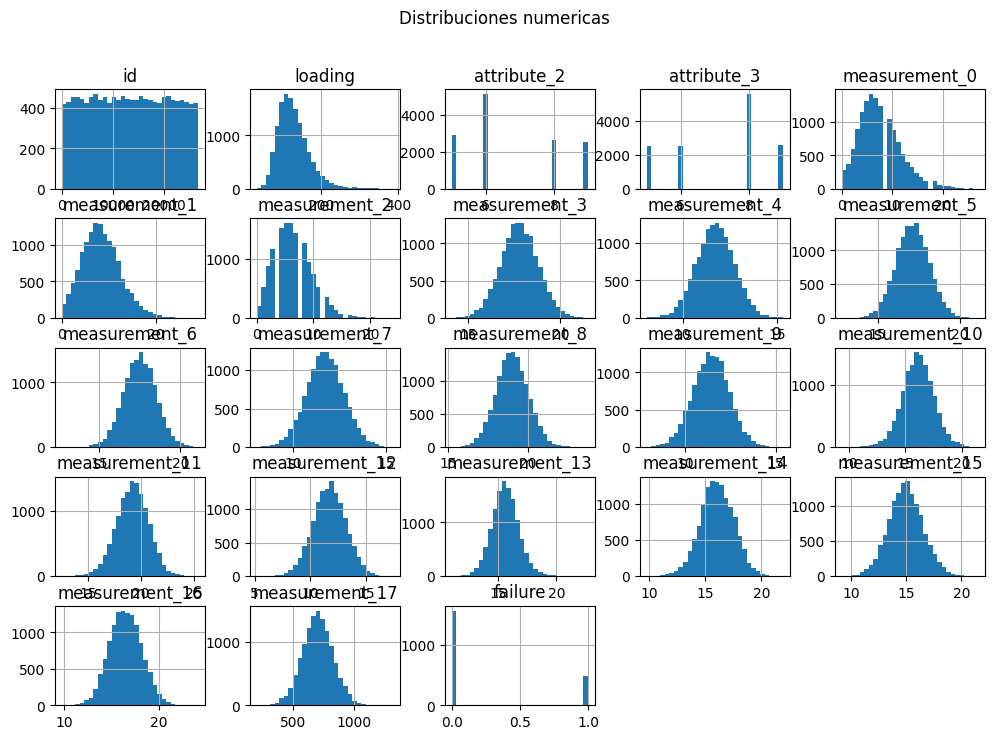

In [5]:
num_df = df_fallos.select_dtypes(include="number")
num_df.hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribuciones numericas")
plt.show()

**Conclusiones**
- La mayoria de mediciones (3-16) muestran distribuciones aproximadamente normales y centradas.
- `loading` y varias mediciones iniciales presentan asimetria hacia la derecha con colas largas.
- `attribute_2` y `attribute_3` aparecen discretas (valores enteros concentrados).
- `failure` es claramente binaria y desbalanceada hacia 0.

### Matriz de correlación. 0.5 puntos

**Objetivo y plan**
- Busco correlaciones altas para detectar redundancias.

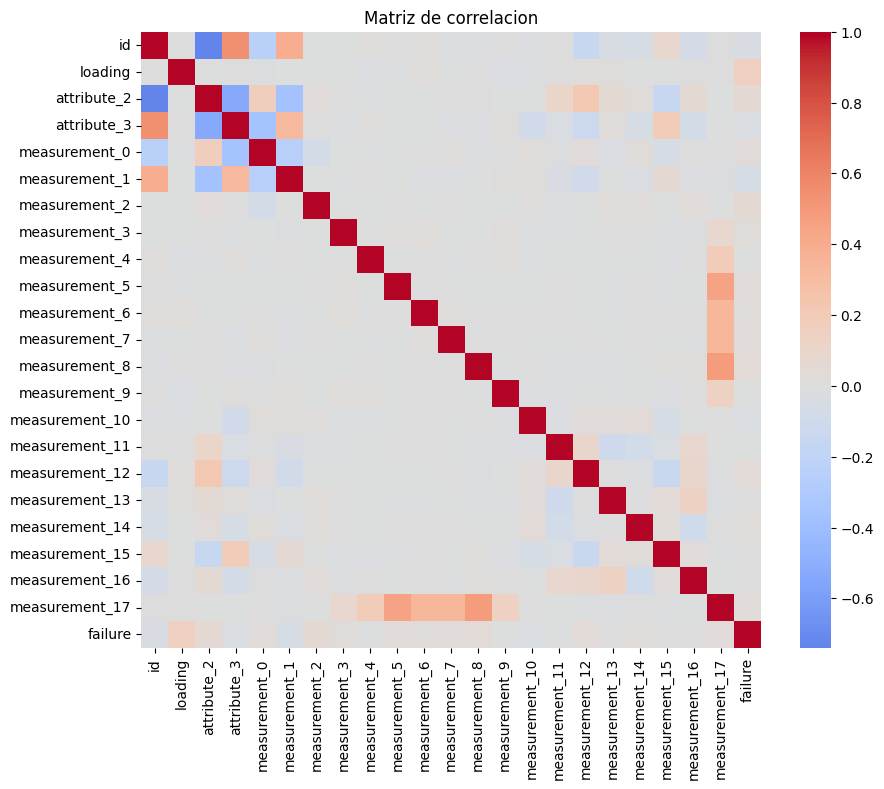

In [6]:
corr = num_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlacion")
plt.show()

**Conclusiones**
- En general no se observan correlaciones muy altas (la matriz esta bastante clara).
- Se aprecia un bloque de correlaciones positivas moderadas entre varias mediciones intermedias (aprox. `measurement_4` a `measurement_9`) y `measurement_17`.
- No hay relaciones lineales fuertes con `failure`, por lo que el modelo tendra que combinar varias senales.

## Realiza el preprocesamiento de datos de tu problema.

**Objetivo y plan**
- Defino columnas numericas y categoricas.
- Preparo el flujo de limpieza y transformaciones.

In [7]:
cat_cols = ["product_code", "attribute_0", "attribute_1"]
num_cols = [c for c in df_fallos.columns if c not in cat_cols + ["failure", "id"]]
print("Categoricas:", cat_cols)
print("Numericas (sin id/failure):", num_cols)

Categoricas: ['product_code', 'attribute_0', 'attribute_1']
Numericas (sin id/failure): ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


**Conclusiones**
- Columnas categoricas confirmadas: `product_code`, `attribute_0`, `attribute_1`.
- Columnas numericas de trabajo: `loading`, `attribute_2`, `attribute_3`, `measurement_0` a `measurement_17` (sin `id` ni `failure`).
- Estrategia se mantiene: imputacion + OneHot + escalado y, si procede, reduccion dimensional con SVD.

### Reserva un conjunto de datos para validación y otro para testeo. 0.5 puntos

**Objetivo y plan**
- Separo labeled/unlabeled.
- Hago split estratificado solo dentro de labeled.
- Dejo valid/test intocables para self-training.

In [8]:
df_labeled = df_fallos[df_fallos["failure"].notna()].copy()
df_unlabeled = df_fallos[df_fallos["failure"].isna()].copy()

X_labeled = df_labeled.drop(columns=["failure", "id"])
y_labeled = df_labeled["failure"].astype(int)

X_unlabeled = df_unlabeled.drop(columns=["failure", "id"])

X_train, X_temp, y_train, y_temp = train_test_split(
    X_labeled, y_labeled, test_size=0.30, stratify=y_labeled, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Labeled:", df_labeled.shape, "Unlabeled:", df_unlabeled.shape)
print("Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)

Labeled: (2032, 26) Unlabeled: (11253, 26)
Train/Valid/Test: (1422, 24) (305, 24) (305, 24)


**Conclusiones**
- Labeled: 2032 filas; Unlabeled: 11253 filas.
- Split etiquetado: train 1422, valid 305, test 305 (aprox. 70/15/15).
- Valid y test salen solo de labeled, por lo que se evita leakage en semisupervisado.

### Columnas inútiles, valores sin sentido y atípicos. 1 punto

**Objetivo y plan**
- Elimino `id` por ser identificador.
- Si aplico reglas de atipicos, las defino solo con train.

In [9]:
# id ya fue eliminada en X_labeled y X_unlabeled
# Reglas de atipicos: si no hay criterio, no elimino por falta de dominio
print("Columnas en X_train:", X_train.columns.tolist())

Columnas en X_train: ['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


**Conclusiones**
- `id` se elimina por ser identificador y no aportar senal predictiva.
- No se aplican reglas de atipicos por falta de criterio de dominio.
- Las columnas de trabajo en `X_train` quedan con 24 features (3 categoricas + 21 numericas).

### Tratamiento de valores nulos. 0.5 puntos

**Objetivo y plan**
- Defino imputadores para numericas y categoricas.
- Integro OneHot y escalado en ColumnTransformer.

In [10]:
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ]
)

print(df_fallos.isna().mean().sort_values(ascending=False).head(10))

failure           0.847046
measurement_17    0.085736
measurement_16    0.081521
measurement_15    0.075574
measurement_14    0.071886
measurement_13    0.067520
measurement_12    0.061950
measurement_11    0.054799
measurement_10    0.048702
measurement_9     0.045766
dtype: float64


**Conclusiones**
- Nulos concentrados en `failure` (84.7%) y en mediciones 9-17 (~4.6% a ~8.6%).
- Se mantiene imputacion con mediana para numericas y moda para categoricas, mas escalado y OneHot en un `ColumnTransformer` (fit solo en train).

### Análisis de variabilidad. 0.5 puntos

**Objetivo y plan**
- Analizo varianza SOLO en numericas de train.
- Elimino columnas con varianza casi cero si aparecen.

In [11]:
# Calculo variabilidad sobre X_train transformado (sparse OK)
if "X_train_proc" not in globals():
    X_train_proc = preprocessor.fit_transform(X_train)

var_selector = VarianceThreshold(threshold=0.0)
var_selector.fit(X_train_proc)
var_series = pd.Series(
    var_selector.variances_,
    index=[f"f_{i}" for i in range(len(var_selector.variances_))],
)
low_var_cols = var_series[var_series < 1e-6].index.tolist()

print("Low variance cols:", len(low_var_cols))

Low variance cols: 0


**Conclusiones**
- No se detectan columnas con varianza casi cero (lista vacia), por lo que no se elimina ninguna feature.

### Columnas categóricas. 0.5 punto

**Objetivo y plan**
- Ajusto OneHot SOLO con train.
- Transformo valid/test/unlabeled con el mismo objeto.

In [12]:
X_train_proc = preprocessor.fit_transform(X_train)
X_valid_proc = preprocessor.transform(X_valid)
X_test_proc = preprocessor.transform(X_test)
X_unlabeled_proc = preprocessor.transform(X_unlabeled)

print("Shape train tras OneHot:", X_train_proc.shape)

Shape train tras OneHot: (1422, 31)


**Conclusiones**
- Tras el OneHot, `X_train` queda con 31 columnas (1422 filas).
- El encoder se ajusta solo con train y se aplica igual a valid/test/unlabeled, evitando leakage.

### Reducción de la dimensionalidad. 1 punto

**Objetivo y plan**
- Reduzco dimensionalidad con TruncatedSVD (apto para sparse).
- Ajusto SOLO con train y busco conservar ~0.90 de varianza.

In [13]:
# Busco n_components que alcance ~0.90 de varianza con train
max_components = min(200, X_train_proc.shape[1] - 1)
if max_components < 2:
    max_components = 2

svd_probe = TruncatedSVD(n_components=max_components, random_state=42)
X_train_probe = svd_probe.fit_transform(X_train_proc)
cum_var = np.cumsum(svd_probe.explained_variance_ratio_)
n_components_90 = int(np.searchsorted(cum_var, 0.90) + 1)
n_components_90 = max(2, min(n_components_90, max_components))

svd = TruncatedSVD(n_components=n_components_90, random_state=42)
X_train_red = svd.fit_transform(X_train_proc)
X_valid_red = svd.transform(X_valid_proc)
X_test_red = svd.transform(X_test_proc)
X_unlabeled_red = svd.transform(X_unlabeled_proc)

print("n_components_90:", n_components_90)
print("Varianza explicada (train):", svd.explained_variance_ratio_.sum())

n_components_90: 19
Varianza explicada (train): 0.9046505607539718


**Conclusiones**
- Se seleccionan 19 componentes y se conserva ~0.905 de varianza explicada en train.
- La reduccion con TruncatedSVD es adecuada para la matriz sparse tras OneHot.

## Realiza un etiquetado automático. 1 punto

**Objetivo y plan**
- Aplico self-training iterativo con threshold 0.90.
- Registro tabla por iteracion y grafico de remaining.

,iter,added,remaining
0,1,6,11247
1,2,1,11246
2,3,0,11246


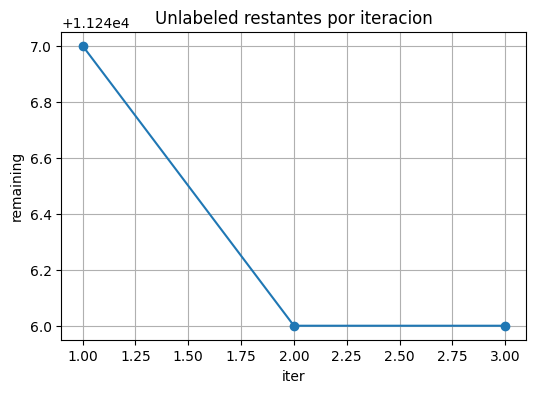

In [14]:
base_model = LogisticRegression(max_iter=2000, class_weight="balanced")
threshold = 0.90
max_iters = 10

X_train_aug = X_train_red.copy()
y_train_aug = y_train.to_numpy().copy()
X_unl = X_unlabeled_red.copy()

history = []
for it in range(1, max_iters + 1):
    if X_unl.shape[0] == 0:
        history.append({"iter": it, "added": 0, "remaining": 0})
        break
    base_model.fit(X_train_aug, y_train_aug)
    proba = base_model.predict_proba(X_unl)
    max_proba = proba.max(axis=1)
    pseudo_mask = max_proba >= threshold
    added = int(pseudo_mask.sum())
    remaining = int(X_unl.shape[0] - added)
    history.append({"iter": it, "added": added, "remaining": remaining})
    if added == 0:
        break
    y_pseudo = proba[pseudo_mask].argmax(axis=1)
    X_train_aug = np.vstack([X_train_aug, X_unl[pseudo_mask]])
    y_train_aug = np.concatenate([y_train_aug, y_pseudo])
    X_unl = X_unl[~pseudo_mask]

history_df = pd.DataFrame(history)
display(history_df)

plt.figure(figsize=(6, 4))
plt.plot(history_df["iter"], history_df["remaining"], marker="o")
plt.title("Unlabeled restantes por iteracion")
plt.xlabel("iter")
plt.ylabel("remaining")
plt.grid(True)
plt.show()

**Conclusiones**
- El self-training anade 6 pseudo-etiquetas en la iteracion 1 y 1 en la iteracion 2; en la iteracion 3 no se anaden mas (paro por umbral).
- Los unlabeled bajan de 11253 a 11246 y luego se estabilizan, coherente con el grafico de remaining.

## Entrena y optimiza distintos modelos supervisados.

**Objetivo y plan**
- Entreno 3 modelos distintos con train_aug.
- Optimizo con CV interno y evalúo en valid.
- Reporto accuracy y f1/balanced_accuracy.

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_results = {}
print("CV listo:", cv)

CV listo: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


### Modelo 1. 1 punto

**Objetivo y plan**
- LogisticRegression con GridSearchCV.
- Evalúo en valid con accuracy y f1.

In [16]:
lr = LogisticRegression(max_iter=3000, class_weight="balanced")
lr_grid = {
    "C": [0.1, 1.0, 10.0],
    "solver": ["lbfgs"],
}
lr_search = GridSearchCV(lr, lr_grid, cv=cv, scoring="balanced_accuracy", n_jobs=-1)
lr_search.fit(X_train_aug, y_train_aug)

lr_best = lr_search.best_estimator_
valid_pred_lr = lr_best.predict(X_valid_red)

model_results["model_1"] = {
    "name": "LogisticRegression",
    "estimator": lr_best,
    "valid_accuracy": accuracy_score(y_valid, valid_pred_lr),
    "valid_f1": f1_score(y_valid, valid_pred_lr),
    "valid_bal_acc": balanced_accuracy_score(y_valid, valid_pred_lr),
    "best_params": lr_search.best_params_,
}
model_results["model_1"]

{'name': 'LogisticRegression',
 'estimator': LogisticRegression(C=10.0, class_weight='balanced', max_iter=3000),
 'valid_accuracy': 0.5868852459016394,
 'valid_f1': 0.35051546391752575,
 'valid_bal_acc': np.float64(0.5472699093943729),
 'best_params': {'C': 10.0, 'solver': 'lbfgs'}}

**Conclusiones**
- Mejor configuracion: `C=10.0` con `solver=lbfgs`.
- Rendimiento en valid: accuracy ~0.587, f1 ~0.351, balanced_accuracy ~0.547.
- Modelo base razonable, pero la f1 baja sugiere desbalanceo y margen de mejora con otros modelos/ensemble.

### Modelo 2. 1 punto

**Objetivo y plan**
- RandomForest con RandomizedSearchCV.
- Evalúo en valid con accuracy y f1.

In [17]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
}
rf_search = RandomizedSearchCV(rf, rf_grid, n_iter=6, cv=cv, scoring="balanced_accuracy", n_jobs=-1, random_state=42)
rf_search.fit(X_train_aug, y_train_aug)

rf_best = rf_search.best_estimator_
valid_pred_rf = rf_best.predict(X_valid_red)

model_results["model_2"] = {
    "name": "RandomForest",
    "estimator": rf_best,
    "valid_accuracy": accuracy_score(y_valid, valid_pred_rf),
    "valid_f1": f1_score(y_valid, valid_pred_rf),
    "valid_bal_acc": balanced_accuracy_score(y_valid, valid_pred_rf),
    "best_params": rf_search.best_params_,
}
model_results["model_2"]

{'name': 'RandomForest',
 'estimator': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=300,
                        random_state=42),
 'valid_accuracy': 0.6983606557377049,
 'valid_f1': 0.23333333333333334,
 'valid_bal_acc': np.float64(0.5242608488316644),
 'best_params': {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 5}}

**Conclusiones**
- Mejor configuracion: `n_estimators=300`, `max_depth=5`, `min_samples_split=2`.
- Rendimiento en valid: accuracy ~0.698, f1 ~0.233, balanced_accuracy ~0.524.
- Accuracy sube, pero f1 baja; indica fuerte desbalanceo y que el modelo prioriza la clase 0.

### Modelo 3. 1 punto

**Objetivo y plan**
- SVC con GridSearchCV y probability=True.
- Evalúo en valid con accuracy y f1.

In [18]:
svc = SVC(probability=True, class_weight="balanced")
svc_grid = {
    "C": [0.5, 1.0, 2.0],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf"],
}
svc_search = GridSearchCV(svc, svc_grid, cv=cv, scoring="balanced_accuracy", n_jobs=-1)
svc_search.fit(X_train_aug, y_train_aug)

svc_best = svc_search.best_estimator_
valid_pred_svc = svc_best.predict(X_valid_red)

model_results["model_3"] = {
    "name": "SVC",
    "estimator": svc_best,
    "valid_accuracy": accuracy_score(y_valid, valid_pred_svc),
    "valid_f1": f1_score(y_valid, valid_pred_svc),
    "valid_bal_acc": balanced_accuracy_score(y_valid, valid_pred_svc),
    "best_params": svc_search.best_params_,
}
model_results["model_3"]

{'name': 'SVC',
 'estimator': SVC(C=0.5, class_weight='balanced', gamma='auto', probability=True),
 'valid_accuracy': 0.580327868852459,
 'valid_f1': 0.28888888888888886,
 'valid_bal_acc': np.float64(0.5045898903195041),
 'best_params': {'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}}

**Conclusiones**
- Mejor configuracion: `C=0.5`, `gamma=auto`, `kernel=rbf` con `probability=True`.
- Rendimiento en valid: accuracy ~0.580, f1 ~0.289, balanced_accuracy ~0.505.
- Desempeno similar al modelo 1; aporta diversidad para el ensemble pese a f1 modesta.

## Crea un modelo ensemble y explica el criterio que utilizas. 1 punto

**Objetivo y plan**
- Hago soft voting con pesos proporcionales al rendimiento en valid.
- Comparo ensemble vs individuales en valid.

In [19]:
weights = [
    model_results["model_1"]["valid_bal_acc"],
    model_results["model_2"]["valid_bal_acc"],
    model_results["model_3"]["valid_bal_acc"],
]

ensemble = VotingClassifier(
    estimators=[
        ("lr", model_results["model_1"]["estimator"]),
        ("rf", model_results["model_2"]["estimator"]),
        ("svc", model_results["model_3"]["estimator"]),
    ],
    voting="soft",
    weights=weights,
)
ensemble.fit(X_train_aug, y_train_aug)

valid_pred_ens = ensemble.predict(X_valid_red)
print("Valid accuracy:", accuracy_score(y_valid, valid_pred_ens))
print("Valid f1:", f1_score(y_valid, valid_pred_ens))
print("Valid balanced_accuracy:", balanced_accuracy_score(y_valid, valid_pred_ens))

Valid accuracy: 0.7278688524590164
Valid f1: 0.1941747572815534
Valid balanced_accuracy: 0.524380066762041


**Conclusiones**
- Se utiliza Soft Voting ponderado por la metrica `balanced_accuracy` de validacion para dar mas voz a los modelos que mejor generalizan.
- En validacion: accuracy 0.7278688524590164, f1 0.1941747572815534 y balanced_accuracy 0.524380066762041.
- Comparo el ensemble frente a los modelos individuales con las mismas metricas para verificar si aporta mejora real.

## Evaluación final (solo test_labeled)

**Objetivo y plan**
- Evalúo una sola vez con test_labeled.
- Reporto matriz de confusión y classification report.

In [20]:
test_pred = ensemble.predict(X_test_red)
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, test_pred))
print("F1:", f1_score(y_test, test_pred))

cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix:\n", cm)
print(classification_report(y_test, test_pred))

Accuracy: 0.7245901639344262
Balanced accuracy: 0.5163717346815938
F1: 0.17647058823529413
Confusion matrix:
 [[212  22]
 [ 62   9]]
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       234
           1       0.29      0.13      0.18        71

    accuracy                           0.72       305
   macro avg       0.53      0.52      0.51       305
weighted avg       0.66      0.72      0.68       305



**Conclusiones**
- En test: accuracy 0.7245901639344262, balanced_accuracy 0.5163717346815938 y f1 0.17647058823529413.
- La matriz de confusion muestra baja deteccion de la clase 1 (recall 0.13), coherente con el desbalanceo del problema.
- Conclusion de negocio: el etiquetado automatico ayuda pero no es suficiente; se necesita mas etiquetado manual para mejorar la deteccion de fallos.

## Asserts anti-leakage

In [21]:
assert y_valid.notna().all() and y_test.notna().all()
assert df_unlabeled["failure"].isna().all()
assert set(X_train.index).isdisjoint(set(X_valid.index))
assert set(X_train.index).isdisjoint(set(X_test.index))
assert set(X_valid.index).isdisjoint(set(X_test.index))
assert df_fallos.loc[X_valid.index, "failure"].notna().all()
assert df_fallos.loc[X_test.index, "failure"].notna().all()
print("Asserts OK")

Asserts OK
